<a href="https://colab.research.google.com/github/beatrizfagundes/news-category-kaggle/blob/master/News_Category_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset description
The News Category Dataset consists of headlines and short descriptions of 200,853 news extracted from HuffPost. Each news instance is labeled with one of the 41 categories listed below:

```
POLITICS: 32739                    WELLNESS: 17827
ENTERTAINMENT: 16058               TRAVEL: 9887
STYLE & BEAUTY: 9649               PARENTING: 8677
HEALTHY LIVING: 6694               QUEER VOICES: 6314
FOOD & DRINK: 6226                 BUSINESS: 5937
COMEDY: 5175                       SPORTS: 4884
BLACK VOICES: 4528                 HOME & LIVING: 4195
PARENTS: 3955                      THE WORLDPOST: 3664
WEDDINGS: 3651                     WOMEN: 3490
IMPACT: 3459                       DIVORCE: 3426
CRIME: 3405                        MEDIA: 2815
WEIRD NEWS: 2670                   GREEN: 2622
WORLDPOST: 2579                    RELIGION: 2556
STYLE: 2254                        SCIENCE: 2178
WORLD NEWS: 2177                   TASTE: 2096
TECH: 2082                         MONEY: 1707
ARTS: 1509                         FIFTY: 1401
GOOD NEWS: 1398                    ARTS & CULTURE: 1339
ENVIRONMENT: 1323                  COLLEGE: 1144
LATINO VOICES: 1129                CULTURE & ARTS: 1030
EDUCATION: 1004
```

- Dataset link: https://www.kaggle.com/rmisra/news-category-dataset#News_Category_Dataset_v2.json

## Goal
The main goal of this task is to create a predictive model which is able to automatically classify the news instances using only the headlines and short descriptions. 

As there are several categories and each instance is labeled with only one category, this is a **Multiclass classification** task. Besides that, one can observe from the counts for each category above that the dataset is **imbalanced**.

In [2]:
# Download news data from Kaggle website - OPTIONAL
# !pip install --user kaggle

# import os
# os.environ['KAGGLE_USERNAME'] = "INSERT HERE THE USERNAME"
# os.environ['KAGGLE_KEY'] = "INSERT HERE THE KEY"

# !kaggle datasets download -d rmisra/news-category-dataset
# !unzip news-category-dataset.zip
# !rm news-category-dataset.zip

 35% 9.00M/25.4M [00:00<00:00, 76.5MB/s]
100% 25.4M/25.4M [00:00<00:00, 125MB/s] 
Archive:  news-category-dataset.zip
replace News_Category_Dataset_v2.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
# Import main libraries

import sys
import os
import json
import re
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.random.seed(3)

In [5]:
# Read the file content and convert it to a Pandas dataframe
news_json = []
for line in open('/content/News_Category_Dataset_v2.json', 'r'):
  news_json.append(json.loads(line))

df = pd.DataFrame(news_json)

# Remove unused columns and move label column to the last column
df = df[['headline', 'short_description', 'category']]
with pd.option_context('display.expand_frame_repr', False): 
  print(df.head())

print('\n' + '-' * 120)
print('=> Number of documents: %d' % df.shape[0])

                                            headline                                  short_description       category
0  There Were 2 Mass Shootings In Texas Last Week...  She left her husband. He killed their children...          CRIME
1  Will Smith Joins Diplo And Nicky Jam For The 2...                           Of course it has a song.  ENTERTAINMENT
2    Hugh Grant Marries For The First Time At Age 57  The actor and his longtime girlfriend Anna Ebe...  ENTERTAINMENT
3  Jim Carrey Blasts 'Castrato' Adam Schiff And D...  The actor gives Dems an ass-kicking for not fi...  ENTERTAINMENT
4  Julianna Margulies Uses Donald Trump Poop Bags...  The "Dietland" actress said using the bags is ...  ENTERTAINMENT

------------------------------------------------------------------------------------------------------------------------
=> Number of documents: 200853


## Exploratory Data Analysis and Preprocessing

- Verify class distribution (how imbalanced is the data) and class integrity (duplicated categories)
- Investigate "headline" and "short_description" characteristics
- Build the features from textual aspects of the news data



=> Number of categories: 39

------------------------------------------------------------------------------------------------------------------------


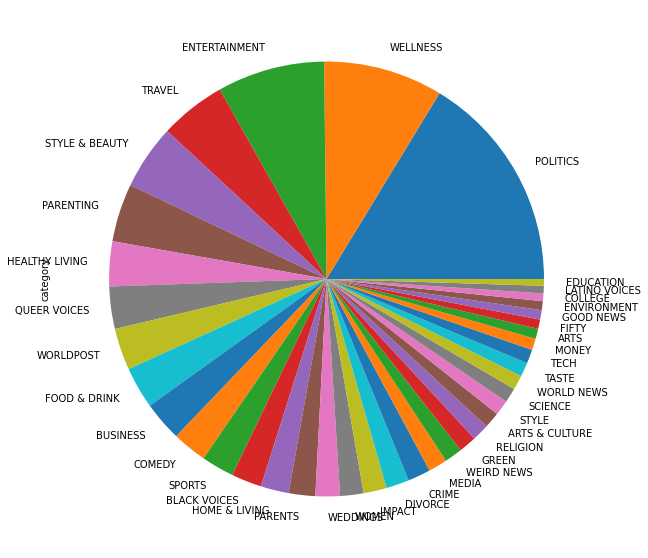

In [6]:
# Merge duplicated categories in the dataset
# THE WORLDPOST and WORLDPOST
# ARTS & CULTURE and CULTURE & ARTS

df.loc[df['category'] == 'THE WORLDPOST', 'category'] = 'WORLDPOST'
df.loc[df['category'] == 'CULTURE & ARTS', 'category'] = 'ARTS & CULTURE'

# Number of categories gets decreased to 39
n_categories = df['category'].nunique()
print('=> Number of categories: %d' % n_categories)

print('\n' + '-' * 120)

# Draw a pie chart for the category column
df['category'].value_counts().plot.pie(figsize=(10, 10))

In [7]:
print('=> Data type of all columns:\n')
print(df.info())

print('\n' + '-' * 120)

print('=> Columns with null value:\n')
print(df.isnull().sum())

=> Data type of all columns:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   headline           200853 non-null  object
 1   short_description  200853 non-null  object
 2   category           200853 non-null  object
dtypes: object(3)
memory usage: 4.6+ MB
None

------------------------------------------------------------------------------------------------------------------------
=> Columns with null value:

headline             0
short_description    0
category             0
dtype: int64


### Apply first preprocessing steps:
- Replace/remove non-words elements such as:
  - Special characters such as emojis
  - Punctuation marks
  - Web URLs
  - Hashtags
  - Mentions (for e.g. @someone)

Although some of these elements might bring information which is useful to find the differences between the news categories, the focus will be in the words and the features that can be derived from them. This kind of features should be the most relevant source of information for this classification task.

In [8]:
# Search for emojis in the headlines and descriptions
emojis_regex = u'([\U00002600-\U000027BF])|([\U0001F1E6-\U0001F1FF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])|([\U0001F910-\U0001F9FF])'

with pd.option_context('display.expand_frame_repr', False): 
  print('=> Emojis on description:\n')
  description_with_emojis = df[df['short_description'].apply(lambda x: True if re.search(emojis_regex, x) else False)]
  print(description_with_emojis)

  print('\n' + '-' * 120)

  print('=> Emojis on headline:\n')
  headline_with_emojis = df[df['headline'].apply(lambda x: True if re.search(emojis_regex, x) else False)]
  print(headline_with_emojis)

  #description_with_emojis['category'].value_counts().plot.pie(figsize=(10, 10))

=> Emojis on description:

                                                 headline                                  short_description        category
141     Rescue Cat Has Hilarious Wide-Eyed Expression ...                                                😻😻😻      WEIRD NEWS
267     Sarah Paulson Is Unapologetic About 32-Year Ag...        And her justification is pretty romantic. 💕    QUEER VOICES
648     Taraji P. Henson And Kelvin Hayden Get Engaged...  The “Empire” star’s NFL boo took a knee and po...   ENTERTAINMENT
665     Ryan Reynolds Went On A South Korean Singing S...  Oh, and he sang “Tomorrow” from the musical “A...   ENTERTAINMENT
822     Tom And Abby From ‘Queer Eye’ Remarried Each O...                   Redneck Margaritas all around! 💕   ENTERTAINMENT
...                                                   ...                                                ...             ...
139152  Victoria's Secret Models Try To Sneak In Flats...  Holiday dress season at Anthro, bye pay

By analyzing the data, one can see that the **emojis** are often used in the place of a word and, therefore, they are important to compose the meaning of some expressions in the dataset. However, replacing them by a default tag `<EMOJI>` within the texts do not seem to affect so much the understanding that the headline or description belongs to its category, that's why this is done here.


In [9]:
def replace_non_words(search_regex, replace, to_be_replaced=None):
  """ Replace elements matching pattern from headlines and short descriptions with another pattern """
  t0 = time()
  if to_be_replaced is None:
    to_be_replaced = search_regex
  for col in ['headline', 'short_description']:
    matched_rows_filter = df[col].apply(lambda x: True if re.search(search_regex, x) else False)
    matched_rows = df[matched_rows_filter]
    print('=> Column: %s' % col)
    print('=> Number of rows: %d' % matched_rows.shape[0])
    df.loc[matched_rows_filter, col] = matched_rows[col].apply(lambda x: re.sub(to_be_replaced, replace, x))
  duration = time() - t0
  print('done in %fs' % duration)


print('=> Replacing emojis...')
replace_non_words(emojis_regex, ' <EMOJI> ')

print('\n' + '-' * 120)
print('=> Replacing URLs...')
url = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'
replace_non_words(url, ' <URL> ')

print('\n' + '-' * 120)
print('=> Replacing hashtags...')
hashtag = r'#(\w+)'
replace_non_words(hashtag, ' <HASHTAG> ')

print('\n' + '-' * 120)
print('=> Replacing mentions...')
mention = r'@(\w+)'
replace_non_words(mention, ' <MENTION> ')

print('\n' + '-' * 120)
print('=> Replacing apostrophes...')
apostrophe = r'[\u2018]|[\u2019]'
replace_non_words(apostrophe, "'")

print('\n' + '-' * 120)
print('=> Removing double quotes...')
double_quotes = r'[\u201c]|[\u201d]'
replace_non_words(double_quotes, '')

print('\n' + '-' * 120)
print('=> Replacing bad words...')
bad_word = r'(\b[\*]\b)|(\S*[\^]\S*)'
replace_non_words(bad_word, '<BAD_WORD>')

print('\n' + '-' * 120)
print('=> Removing dots and commas used inside numbers...')
numeric_delimiter = r'\d[\,\.]\d'
replace_non_words(numeric_delimiter, '', r'[\,\.]')

# To avoid removing numeric values with slash such as dates (9/11) and common expressions (24/7)
print('\n' + '-' * 120)
print('=> Removing slashes in the middle of words...')
slash = r'([a-zA-Z]+|\s)\/([a-zA-Z]+|\s)'
replace_non_words(slash, ' ', r'\/')

# To avoid removing hyphen from hyphenated expressions
print('\n' + '-' * 120)
print('=> Removing hyphens not used on hyphenated expressions...')
hyphenated = r'\s\-\s'
replace_non_words(hyphenated, ' ')

print('\n' + '-' * 120)
print('=> Replacing monetary values...')
currency = r'\$\d+'
replace_non_words(currency, ' <CURRENCY> ')

print('\n' + '-' * 120)
print('=> Removing some other special characters...')
punctuation = r'[\:\;\-\=\$\%\"\(\)\[\]\{\}\*\+\~\^\_\|\\]'
replace_non_words(punctuation, ' ')

print('\n' + '-' * 120)
print('=> Removing multiple blank spaces...')
multiple_spaces = r'\s{2,}'
replace_non_words(multiple_spaces, ' ')

print('\n' + '-' * 120)
print('=> Replacing misspelled words (words with any character repeating 3 times or more)...')
misspelled = r'\b\w*(\w)\1\1+\w+\b'
replace_non_words(misspelled, ' <MISSPELLED> ')


=> Replacing emojis...
=> Column: headline
=> Number of rows: 3
=> Column: short_description
=> Number of rows: 832
done in 4.413590s

------------------------------------------------------------------------------------------------------------------------
=> Replacing URLs...
=> Column: headline
=> Number of rows: 2
=> Column: short_description
=> Number of rows: 166
done in 2.817358s

------------------------------------------------------------------------------------------------------------------------
=> Replacing hashtags...
=> Column: headline
=> Number of rows: 752
=> Column: short_description
=> Number of rows: 607
done in 0.377395s

------------------------------------------------------------------------------------------------------------------------
=> Replacing mentions...
=> Column: headline
=> Number of rows: 17
=> Column: short_description
=> Number of rows: 693
done in 0.375876s

--------------------------------------------------------------------------------------------

=> Column with empty strings:

headline                 6
short_description    19717
category                 0
dtype: int64

------------------------------------------------------------------------------------------------------------------------
=> Column with empty strings (just to check if previous action removed the empty values):

headline             0
short_description    0
category             0
dtype: int64

------------------------------------------------------------------------------------------------------------------------
=> Updated number of documents: 181135


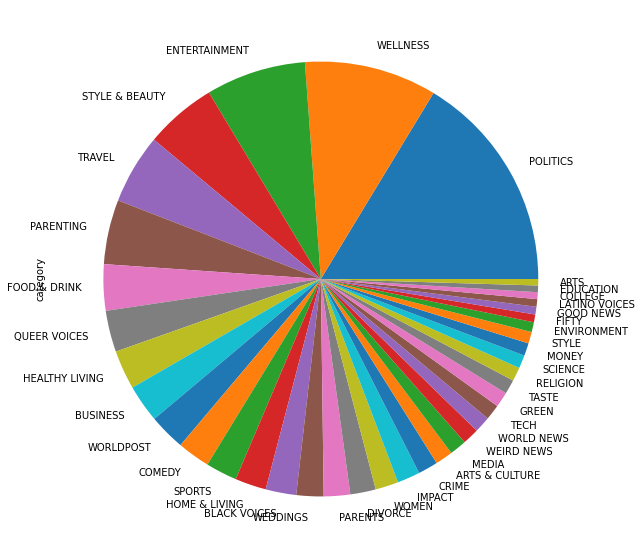

In [10]:
# Replace empty strings with NA
df = df.replace(r'^\s*$', np.nan, regex=True)
print('=> Column with empty strings:\n')
print(df.isnull().sum())

print('\n' + '-' * 120)

# Remove instances with blank 'headline' or blank 'short_description' 
df.dropna(inplace=True)

print('=> Column with empty strings (just to check if previous action removed the empty values):\n')
print(df.isnull().sum())

print('\n' + '-' * 120)

print('=> Updated number of documents: %d' % df.shape[0])

df['category'].value_counts().plot.pie(figsize=(10, 10))

### Beyond single-word (unigrams) features 

The most common features used in text classification tasks are the words (unigrams), but several researches have proven that the list of features can be enriched with other hand crafted features extracted from the textual characteristics, such as:

- Text length
- Count of some POS tags (e.g. count of nouns, count of verbs, ...)
- Count of Out-of-vocabulary (OOV) words
- Measures regarding text readability
  - Count of misspelled words
  - Average word length
  - Average sentence length
  - Average number of words per sentence
- Minimum, maximum, and average inverse document frequency (IDF) 
- Sentiment polarity level
- Dependency Parsing measures
  - Amount of nouns connected by verbs
- Named Entity Recognition metrics
  - Count of occurrences of some entity type

Some of those hand crafted feature are going to be explored in the following sections.

### Text length

In [0]:
# !pip install -U spacy
# !python -m spacy download en_core_web_sm

from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
import spacy

nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'ner'])

In [9]:
news_len = { 
  'description': df['short_description'],
  'descriptionLen': df['short_description'].apply(lambda x: len(nlp(x))),
  'headline': df['headline'],
  'headlineLen': df['headline'].apply(lambda x: len(nlp(x))),
  'category': df['category']
}
df_len = pd.DataFrame(data=news_len, columns=['description', 'descriptionLen', 'headline', 'headlineLen', 'category'])

with pd.option_context('display.expand_frame_repr', False): 
  df_headline = df_len[['headline', 'headlineLen', 'category']].sort_values('headlineLen', ascending=False)
  print('Longest headlines:')
  print(df_headline.head(10))
  
  print('\n' + '-' * 120)
  print('Shortest headlines:')
  print(df_headline.tail(10))
  
  df_description = df_len[['description', 'descriptionLen', 'category']].sort_values('descriptionLen', ascending=False)
  print('\n' + '-' * 120)
  print('Longest descriptions:')
  print(df_description.head(10))

  print('\n' + '-' * 120)
  print('Shortest descriptions:')
  print(df_description.tail(10))

Longest headlines:
                                                 headline  headlineLen        category
50290   Chats with Esperanza Spalding, Michelle Philli...           59   ENTERTAINMENT
49657   Chats With Todd Rundgren, Don McLean, Sean Cal...           46   ENTERTAINMENT
112885  'How Do We Treat the Little People, Joan?' I A...           40   ENTERTAINMENT
194995  Queer Celebrities Need Love, Too Part 2 An Int...           36    QUEER VOICES
192821  Was Einstein The World's Worst Husband? Wife O...           34         DIVORCE
139564  Fashion Forward Pop Up Disguised as M<BAD WORD...           33  STYLE & BEAUTY
55122   Inmates Running the Asylum Marat Sade The Pers...           33  ARTS & CULTURE
161080  'G.I. Joe Retaliation' Reviews, Lil' Wayne's '...           32   ENTERTAINMENT
88505   Top 3 Reasons Why 400 ppm CO2 Is Is Not the En...           32           GREEN
165074  'A Good Day To Die Hard' Reviews, Nataly Dawn'...           31   ENTERTAINMENT

-----------------------

=> Generate descriptive statistics:
       descriptionLen    headlineLen
count   181135.000000  181135.000000
mean        24.973594      10.573705
std         15.059718       3.641996
min          1.000000       1.000000
25%         14.000000       8.000000
50%         22.000000      11.000000
75%         30.000000      13.000000
max        286.000000      59.000000


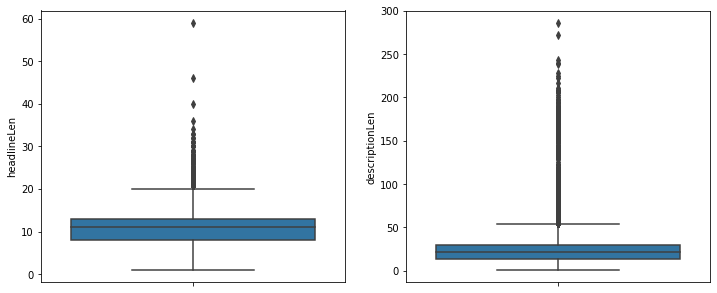

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
sns.boxplot(y='headlineLen', data=df_len, ax=ax[0])
sns.boxplot(y='descriptionLen', data=df_len, ax=ax[1])
fig.show()

print('=> Generate descriptive statistics:')
print(df_len.describe())

In [12]:
# Combine headline with short description into one single text
df['news_text'] = df['headline'] + '. ' + df['short_description']

# Leave in the dataframe only the news_document and category columns
df = df[['news_text', 'category']]

with pd.option_context('display.expand_frame_repr', False): 
  print(df.head(2))

                                           news_text       category
0  There Were 2 Mass Shootings In Texas Last Week...          CRIME
1  Will Smith Joins Diplo And Nicky Jam For The 2...  ENTERTAINMENT


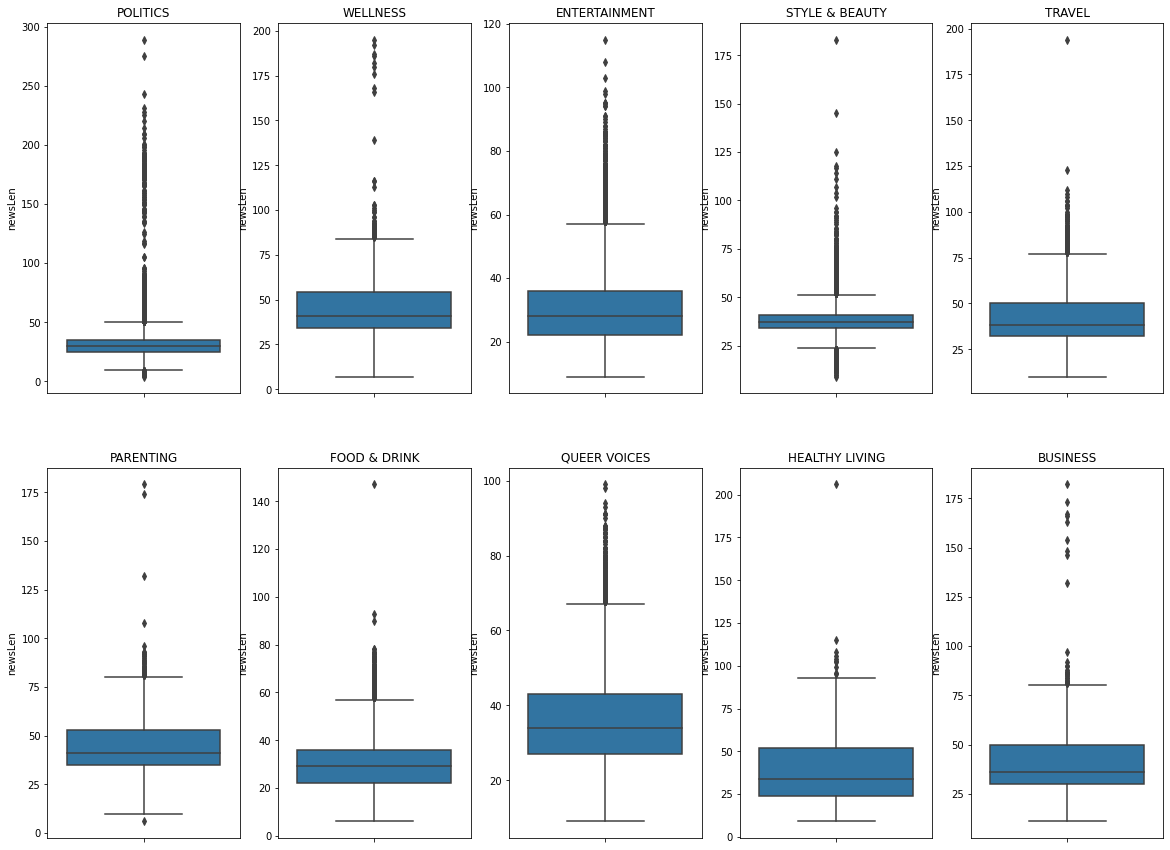

In [13]:
# Check text length variation for the top 10 categories with more instances
top_10 = df['category'].value_counts()[:10].index.values

news_len = {
  'newsLen': df['news_text'].apply(lambda x: len(nlp(x))),
  'category': df['category']
}
df_len = pd.DataFrame(data=news_len, columns=['newsLen', 'category'])

fig, ax = plt.subplots(2, 5, figsize=(20, 15))

for category in top_10:
  j = list(top_10).index(category)
  i = 0
  if j >= 5:
    j = j % 5
    i = 1
  sns.boxplot(y='newsLen', data=df_len[df_len['category'] == category], ax=ax[i,j])
  ax[i, j].title.set_text(category)

From the charts above, one can check that the text length present a significant variation among the categories (at least the largest ones). Therefore, the text length may be an useful feature for this classification task. 

In [14]:
df['news_length'] = df_len['newsLen'] 
df.head()

,news_text,category,news_length
0,There Were 2 Mass Shootings In Texas Last Week...,CRIME,32
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT,23
2,Hugh Grant Marries For The First Time At Age 5...,ENTERTAINMENT,27
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT,30
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT,29


### POS Tags and Named entities

In [15]:
nlp = spacy.load('en_core_web_sm', disable=['parser'])

# List of POS tags: https://github.com/explosion/spaCy/blob/master/spacy/lang/en/tag_map.py
nouns = ['NOUN', 'PROPN']
punct = ['PUNCT']
verb = ['VERB']

tags_percentage = {
  'pos_noun': np.zeros(df.shape[0]),
  'pos_punct': np.zeros(df.shape[0]),
  'pos_verb': np.zeros(df.shape[0])
}

# List of entities: https://spacy.io/api/annotation#named-entities
people = ['PERSON', 'ORG']
location = ['GPE', 'LOC', 'FAC']

entities_percentage = {
  'er_people': np.zeros(df.shape[0]),
  'er_location': np.zeros(df.shape[0])
}

t0 = time()
print('=> Extracting POS tags and Named entities...')
doc_index = 0
# Build a spacy pipeline to traverse all news text and extract POS tags and Named entities information
for doc in nlp.pipe(df['news_text'].values, batch_size=50, n_threads=3):
  # POS tags
  for token in doc:
    if token.pos_ in nouns:
      tags_percentage['pos_noun'][doc_index] += 1
    elif token.pos_ in punct:
      tags_percentage['pos_punct'][doc_index] += 1
    elif token.pos_ in verb:
      tags_percentage['pos_verb'][doc_index] += 1
  # Named entities
  for ent in doc.ents:
    if ent.label_ in people:
      entities_percentage['er_people'][doc_index] += 1
    elif ent.label_ in location:
      entities_percentage['er_location'][doc_index] += 1
  doc_index += 1
  if doc_index % 10000 == 0:
    print('%ith document processed' % doc_index)

duration = time() - t0
print('done in %fs' % duration)

=> Extracting POS tags and Named entities...
10000th document processed
20000th document processed
30000th document processed
40000th document processed
50000th document processed
60000th document processed
70000th document processed
80000th document processed
90000th document processed
100000th document processed
110000th document processed
120000th document processed
130000th document processed
140000th document processed
150000th document processed
160000th document processed
170000th document processed
180000th document processed
done in 613.976807s


In [16]:
# Merge the new features into the dataframe df
df_tags = pd.DataFrame(data={**tags_percentage , **entities_percentage})
df.reset_index(inplace=True,  drop=True)
df = pd.concat([df, df_tags], axis=1)
df.tail()

,news_text,category,news_length,pos_noun,pos_punct,pos_verb,er_people,er_location
181130,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,33,16.0,5.0,2.0,5.0,0.0
181131,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,36,15.0,6.0,1.0,4.0,0.0
181132,"Giants Over Patriots, Jets Over Colts Among Mo...",SPORTS,44,14.0,4.0,5.0,1.0,0.0
181133,Aldon Smith Arrested 49ers Linebacker Busted F...,SPORTS,29,15.0,1.0,1.0,3.0,0.0
181134,Dwight Howard Rips Teammates After Magic Loss ...,SPORTS,31,16.0,1.0,3.0,1.0,1.0


In [17]:
# Scale values from POS tags and Named entities features dividing the value by the value in news_length
features = ['pos_noun', 'pos_punct', 'pos_verb', 'er_people', 'er_location']
for f in features:
  df[f] = df[f] / df['news_length']
df.tail()

,news_text,category,news_length,pos_noun,pos_punct,pos_verb,er_people,er_location
181130,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,33,0.484848,0.151515,0.060606,0.151515,0.000000
181131,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,36,0.416667,0.166667,0.027778,0.111111,0.000000
181132,"Giants Over Patriots, Jets Over Colts Among Mo...",SPORTS,44,0.318182,0.090909,0.113636,0.022727,0.000000
181133,Aldon Smith Arrested 49ers Linebacker Busted F...,SPORTS,29,0.517241,0.034483,0.034483,0.103448,0.000000
181134,Dwight Howard Rips Teammates After Magic Loss ...,SPORTS,31,0.516129,0.032258,0.096774,0.032258,0.032258


In [18]:
# Set a maximum lenght based on what was observed from the previous dataset analyses 
max_length = 1000

# Scale news_length column in order to have a value between 0 and 1
df['news_length'] = df['news_length'] / max_length
df.tail()

,news_text,category,news_length,pos_noun,pos_punct,pos_verb,er_people,er_location
181130,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,0.033,0.484848,0.151515,0.060606,0.151515,0.000000
181131,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,0.036,0.416667,0.166667,0.027778,0.111111,0.000000
181132,"Giants Over Patriots, Jets Over Colts Among Mo...",SPORTS,0.044,0.318182,0.090909,0.113636,0.022727,0.000000
181133,Aldon Smith Arrested 49ers Linebacker Busted F...,SPORTS,0.029,0.517241,0.034483,0.034483,0.103448,0.000000
181134,Dwight Howard Rips Teammates After Magic Loss ...,SPORTS,0.031,0.516129,0.032258,0.096774,0.032258,0.032258


### Build TFIDF model

=> List of categories following the category ids sequence: 
['CRIME' 'ENTERTAINMENT' 'WORLD NEWS' 'IMPACT' 'POLITICS' 'WEIRD NEWS'
 'BLACK VOICES' 'WOMEN' 'COMEDY' 'QUEER VOICES' 'SPORTS' 'BUSINESS'
 'TRAVEL' 'MEDIA' 'TECH' 'RELIGION' 'SCIENCE' 'LATINO VOICES' 'EDUCATION'
 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'WORLDPOST' 'GOOD NEWS' 'FIFTY' 'ARTS' 'WELLNESS'
 'PARENTING' 'HOME & LIVING' 'STYLE & BEAUTY' 'DIVORCE' 'WEDDINGS'
 'FOOD & DRINK' 'MONEY' 'ENVIRONMENT']

=> Checking if the category sequence really holds


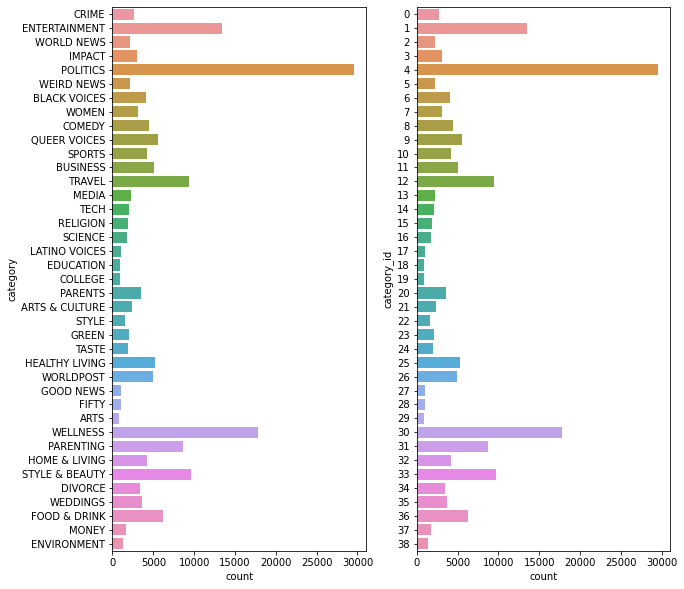

In [19]:
# Create the column category_id with an integer representation for each categorical value from category column
codes, uniques = df['category'].factorize()
df['category_id'] = codes
categories_indexed = uniques.values

print('=> List of categories following the category ids sequence: ')
print(categories_indexed)

print('\n=> Checking if the category sequence really holds')
fig, ax = plt.subplots(1,2,figsize=(10,10))
sns.countplot(y='category', data=df, order=categories_indexed, ax=ax[0])
sns.countplot(y='category_id', data=df, ax=ax[1])

=> Number of instances in the TRAINING data: 135851
=> Number of instances in the TEST data: 45284

------------------------------------------------------------------------------------------------------------------------


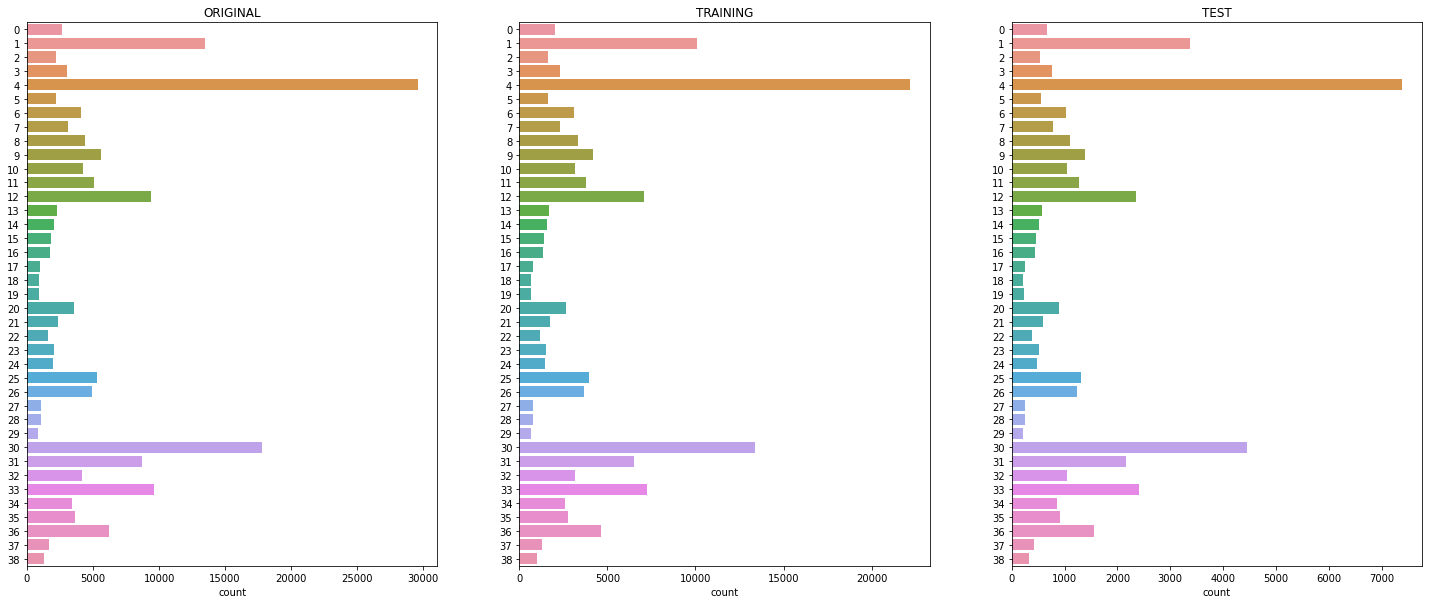

In [20]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.25, stratify=df['category'].values)

print('=> Number of instances in the TRAINING data: %d' % df_train.shape[0])
print('=> Number of instances in the TEST data: %d' % df_test.shape[0])

print('\n' + '-' * 120)

# Plot to verifiy that the training and test data are indeed stratified samples from the original data
fig, ax = plt.subplots(1, 3, figsize=(25, 10))
sns.countplot(y=df['category_id'].values, ax=ax[0])
ax[0].set_title('ORIGINAL')
sns.countplot(y=df_train['category_id'].values, ax=ax[1])
ax[1].set_title('TRAINING')
sns.countplot(y=df_test['category_id'].values, ax=ax[2])
ax[2].set_title('TEST')
fig.show()


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def spacy_tokenizer(doc):
  tokens = nlp(doc)
  tokens = [ t.lemma_ for t in tokens if t.text.lower() not in stop_words ]
  return tokens

tfidf_vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer, sublinear_tf=True)

t0 = time()
print('=> Building TFIDF representation...')

tfidf_vectorizer.fit(df_train['news_text'])

duration = time() - t0
print('done in %fs' % duration)

print('\n' + '-' * 120)

print('=> Vocabulary size: %d' % len(tfidf_vectorizer.vocabulary_))

X_train = tfidf_vectorizer.transform(df_train['news_text'])
X_test = tfidf_vectorizer.transform(df_test['news_text'])


=> Building TFIDF representation...


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


done in 46.059187s

------------------------------------------------------------------------------------------------------------------------
=> Vocabulary size: 60075


Since the dimensionality of the unigram vectors is too high, Chi Square technique will be applied to reduce this size and avoid handling with the issues related to the curse of dimensionality.

In [33]:
from sklearn.feature_selection import SelectKBest, chi2

y_train = df_train['category_id'].values
y_test = df_test['category_id'].values

# Reduce number of features by using Chi Square technique
# Select the top 8000 best features 

ch2 = SelectKBest(chi2, k=8000)
X_train_chi = ch2.fit_transform(X_train, y_train)
X_test_chi = ch2.transform(X_test)

X_train_chi

<135851x8000 sparse matrix of type '<class 'numpy.float64'>'
	with 1808741 stored elements in Compressed Sparse Row format>

In [34]:
features_names = tfidf_vectorizer.get_feature_names()                              
chi2score = chi2(X_train, y_train)[0]                                                  
wscores = zip(features_names, chi2score)                                   
wchi2 = sorted(wscores, key=lambda x:x[1], reverse=True)
wchi2[:30]

[('divorce', 18307.287815208456),
 ('wed', 13292.565031203241),
 ('gay', 6236.038971550234),
 ('recipe', 5847.529607779241),
 ('wedding', 4921.249791671303),
 ('bride', 4453.491194953133),
 ('trump', 4331.666147720579),
 ('photo', 3824.7964748591426),
 ('latino', 3522.701638499613),
 ('black', 3388.794979075738),
 ('fashion', 3226.723654150816),
 ('travel', 3204.4820959972276),
 ('latinos', 3085.616993274914),
 ('style', 3054.5040325617956),
 ('queer', 2966.9533121292297),
 ('marriage', 2879.1593715414583),
 ('college', 2854.277154920669),
 ('home', 2721.6540042116217),
 ('kid', 2679.7070733824207),
 ('parent', 2648.0189506466763),
 ('lgbt', 2534.69816824515),
 ('apple', 2505.8951077792085),
 ('lgbtq', 2454.1485399808375),
 ('child', 2426.337541403397),
 ('education', 2410.405771441281),
 ('nasa', 2344.1915539707143),
 ('marry', 2271.507937791525),
 ('mom', 2271.3202954528915),
 ('climate', 2219.954998870002),
 ("'", 2167.7854334631993)]

By looking to this small sample of features, it seems that Chi Square extracted meaningful features related to several categories from the dataset. 

In [36]:
from scipy.sparse import coo_matrix, hstack

# Merge hand crafted features with TFIDF
hand_crafted = ['news_length', 'pos_noun', 'pos_punct', 'pos_verb', 'er_people', 'er_location']
X_train_all = hstack([X_train_chi, coo_matrix(df_train[hand_crafted].values)])
X_test_all = hstack([X_test_chi, coo_matrix(df_test[hand_crafted].values)])
X_train_all

<135851x8006 sparse matrix of type '<class 'numpy.float64'>'
	with 2463863 stored elements in COOrdinate format>

## Classification Models

1. Build a baseline model for each classifier (SVM linear and Logistic Regression) using only TFIDF representation
2. Compare the baseline with a new model built using the TFIDF representation + hand crafted features
3. Compare both of them using a Neural Network with a Embedding layer which learns the word embeddings from the news_text data

### Baseline models

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                precision    recall  f1-score   support

         CRIME       0.57      0.46      0.51       802
 ENTERTAINMENT       0.56      0.78      0.65      4041
    WORLD NEWS       0.52      0.16      0.24       652
        IMPACT       0.47      0.23      0.31       918
      POLITICS       0.65      0.87      0.74      8873
    WEIRD NEWS       0.48      0.24      0.32       663
  BLACK VOICES       0.59      0.35      0.44      1237
         WOMEN       0.43      0.29      0.34       931
        COMEDY       0.64      0.41      0.50      1325
  QUEER VOICES       0.80      0.64      0.71      1671
        SPORTS       0.74      0.68      0.71      1266
      BUSINESS       0.50      0.48      0.49      1523
        TRAVEL       0.68      0.82      0.74      2822
         MEDIA       0.60      0.32      0.42       683
          TECH       0.63      0.41      0.49       624
      RELIGION       0.60      0.37      0.46       557
       SCIENCE       0.70      0.41      0.52  

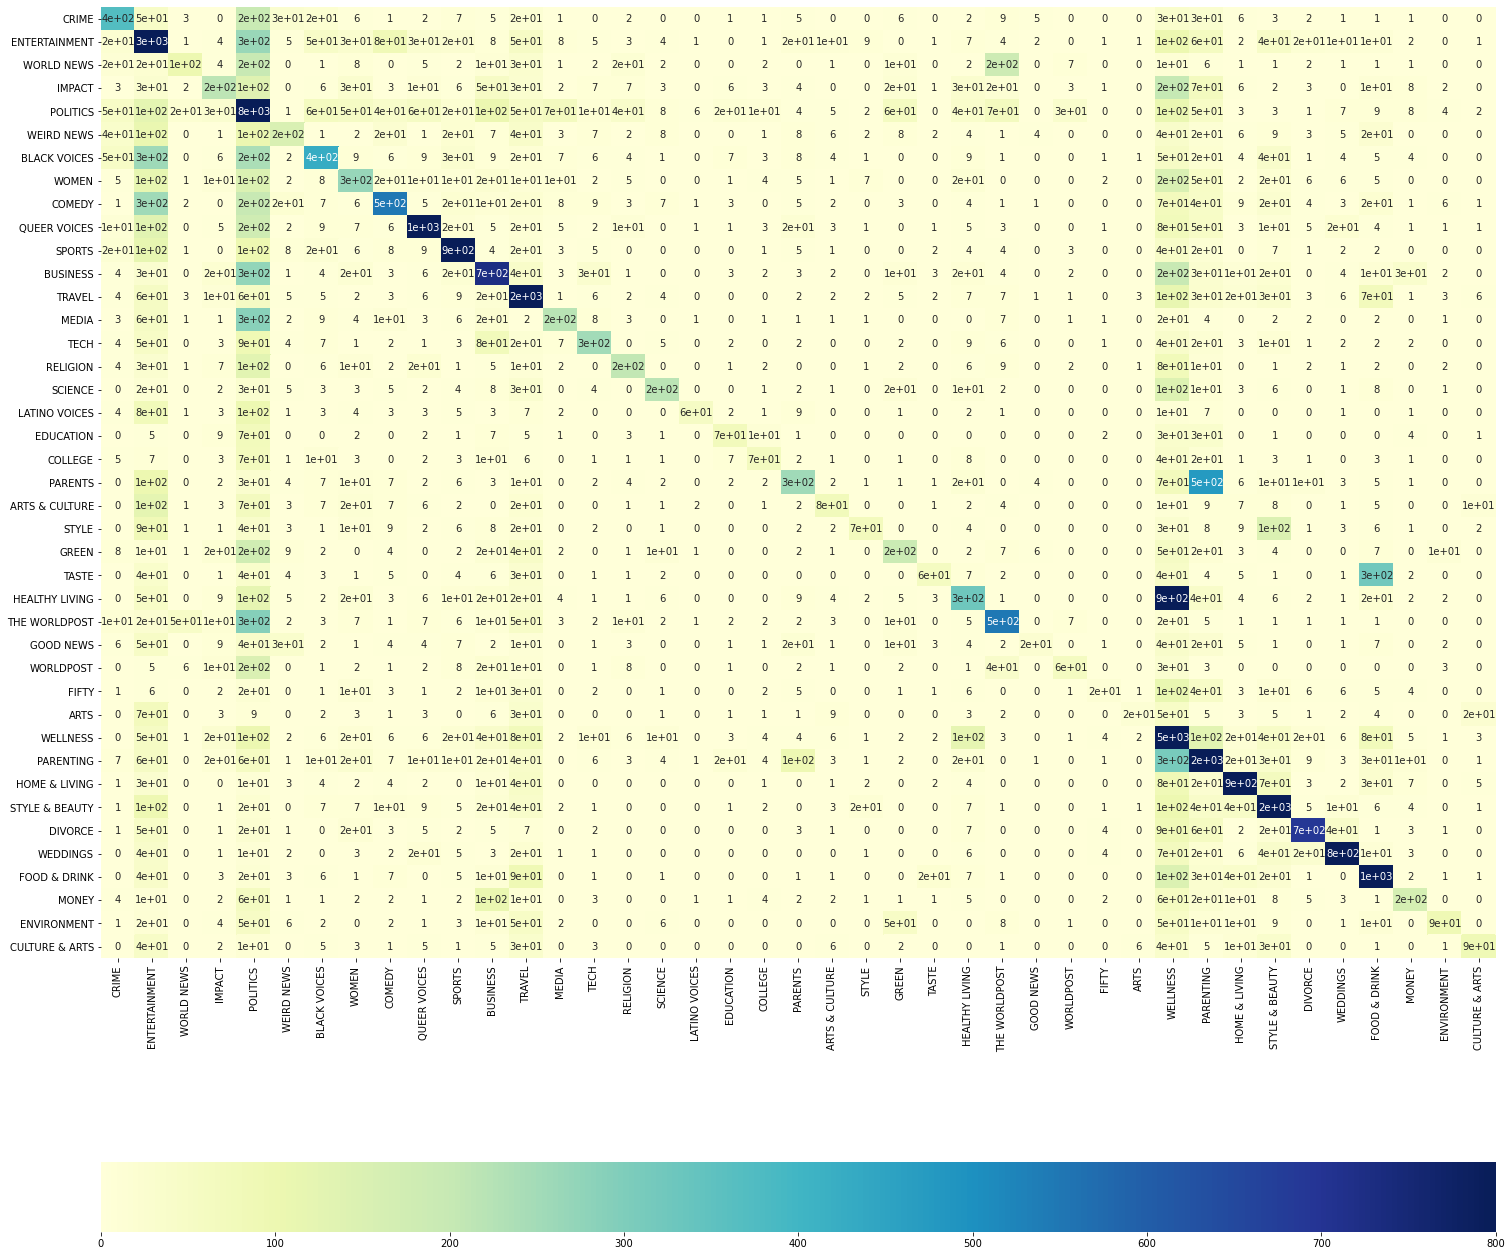

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Logistic regression can be used in the baseline because it works well when the relationship between the features and the class aren’t too complex.
# https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451
classifier = LogisticRegression(max_iter=500)

classifier.fit(X_train_tfidf, y_train)

y_pred = classifier.predict(X_test_tfidf)

print(classification_report(y_test, y_pred, target_names=categories_indexed))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = categories_indexed, columns = categories_indexed)
plt.figure(figsize=(25,25))
sns.heatmap(df_cm, vmin=0, vmax=800, annot=True, cmap='YlGnBu', fmt='.1g', cbar_kws={"orientation": "horizontal"})

                precision    recall  f1-score   support

         CRIME       0.55      0.51      0.53       802
 ENTERTAINMENT       0.63      0.73      0.68      4041
    WORLD NEWS       0.42      0.25      0.31       652
        IMPACT       0.39      0.28      0.33       918
      POLITICS       0.70      0.83      0.76      8873
    WEIRD NEWS       0.38      0.27      0.32       663
  BLACK VOICES       0.53      0.42      0.47      1237
         WOMEN       0.40      0.29      0.33       931
        COMEDY       0.55      0.44      0.49      1325
  QUEER VOICES       0.76      0.70      0.73      1671
        SPORTS       0.70      0.74      0.72      1266
      BUSINESS       0.48      0.47      0.48      1523
        TRAVEL       0.72      0.80      0.76      2822
         MEDIA       0.54      0.41      0.46       683
          TECH       0.54      0.49      0.51       624
      RELIGION       0.55      0.48      0.52       557
       SCIENCE       0.63      0.51      0.56  

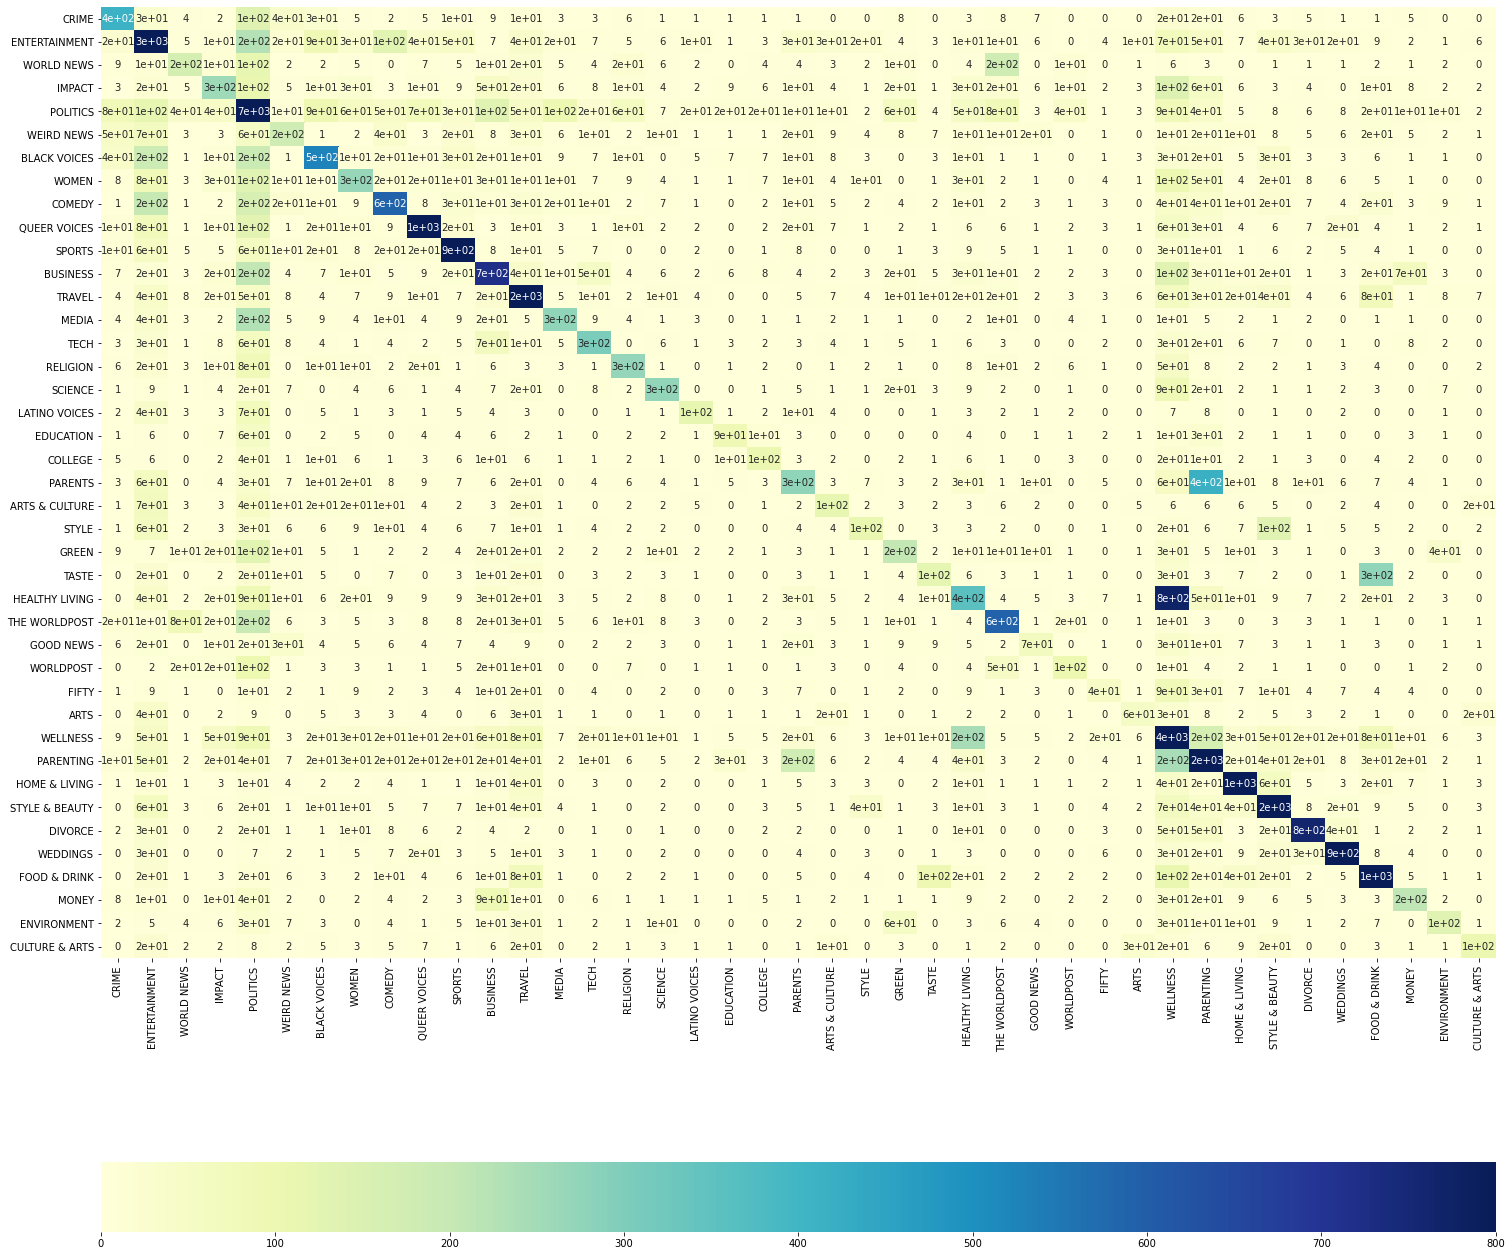

In [95]:
from sklearn.svm import LinearSVC

classifier = LinearSVC()

classifier.fit(X_train_tfidf, y_train)

y_pred = classifier.predict(X_test_tfidf)

print(classification_report(y_test, y_pred, target_names=categories_indexed))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = categories_indexed, columns = categories_indexed)
plt.figure(figsize=(25,25))
sns.heatmap(df_cm, vmin=0, vmax=800, annot=True, cmap='YlGnBu', fmt='.1g', cbar_kws={"orientation": "horizontal"})